# **Data Visualisation** 

## Objectives

Answer **business requirement 1:**
- The client is interested in conducting a study to visually differentiate the differences between average healthy and average powdery mildew cherry leaves. 

## Inputs

* inputs/cherryleaves_dataset/leaf_images/train 
* inputs/cherryleaves_dataset/leaf_images/validation
* inputs/cherryleaves_dataset/leaf_images/test 

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinuish the contrast between healthy and powdery mildew infected leaves.
* Generate code that answers business requirment 1 and can be used to build an image montage to be displayed on the dashboard. 




## Import Libraries 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("whitegrid")
from matplotlib.image import imread

Matplotlib is building the font cache; this may take a moment.


# Set working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-cherry-leaves-p5/jupyter_notebooks'

Setting new directory 

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd() # work_dir = os.getced()
work_dir 

'/workspaces/mildew-detection-cherry-leaves-p5'

## Set inputs directories 

### Set train, validation, and test paths 

In [9]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'
my_data_dir

'inputs/cherryleaves_dataset/cherry-leaves'

### Set output directory 

In [10]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### Set label names 

In [11]:
# set the data labels
labels = os.listdir(train_path)
print('Labels for the images are', labels)

Labels for the images are ['powdery_mildew', 'healthy']


---
# Data Visualisation of Image Data 
---

## Image Shape 

Calculate average image size on train set:

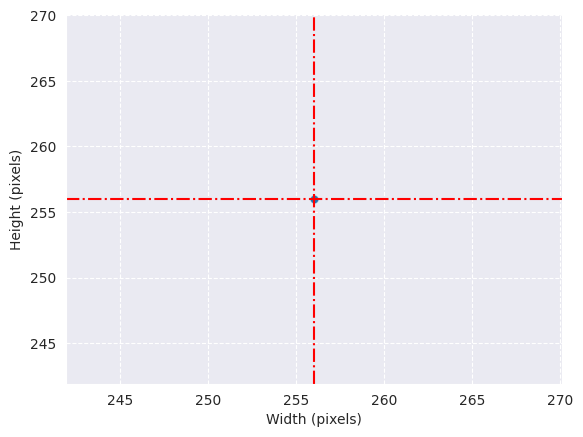

Width average: 256 
Height average: 256


In [12]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("darkgrid", {'grid.linestyle': '--'}) 
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='-.')
axes.axhline(y=dim2_mean, color='r', linestyle='-.')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}") 

In [13]:
image_shape = (dim1_mean, dim2_mean, 3) 
image_shape

(256, 256, 3)

Images are 256 x 256 pixels. They must be reduced to a size of 50 x 50 pixels each, in order to stay in line with file storage restrictions. 

Save image shape embeddings:

In [14]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl") 

['outputs/v1/image_shape.pkl']

---

# Average and Variability of Images per Label 

* Function loads images in an array (tensor).
* Utilises image module of tensorflow keras library. 

In [16]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label = 20):
    """
    The function creates two arrays, one with images and the other with labels.
    Used to analyse preprocessed images  
    """
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1
    
    return X, y 

### Load images shape and labels in an array 

In [17]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape) 

(60, 256, 256, 3) (60,)


###  Plot and save mean and variability of images per label:


In [18]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    Function loops over all labels, and subsets an array for a given label
    Calculates the mean and standard deviation
    Then creates a figure displaying mean and variability of images
    Saves the image 
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0) 
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")        

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


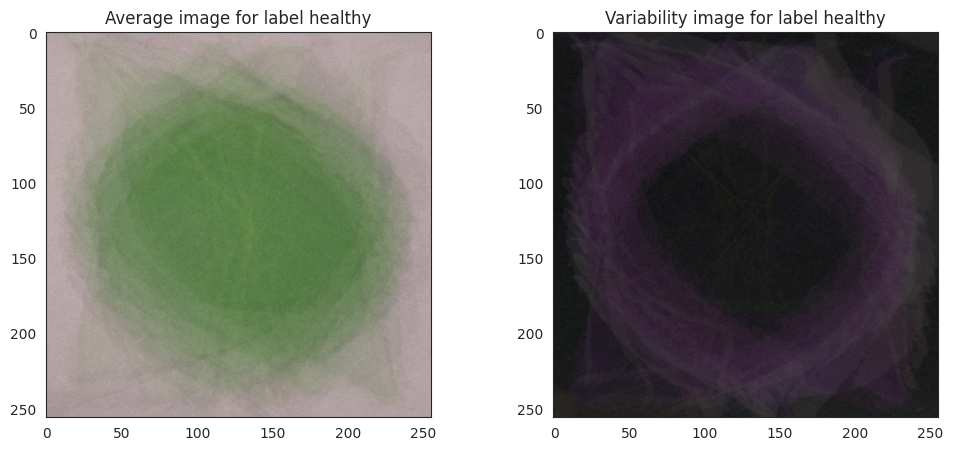

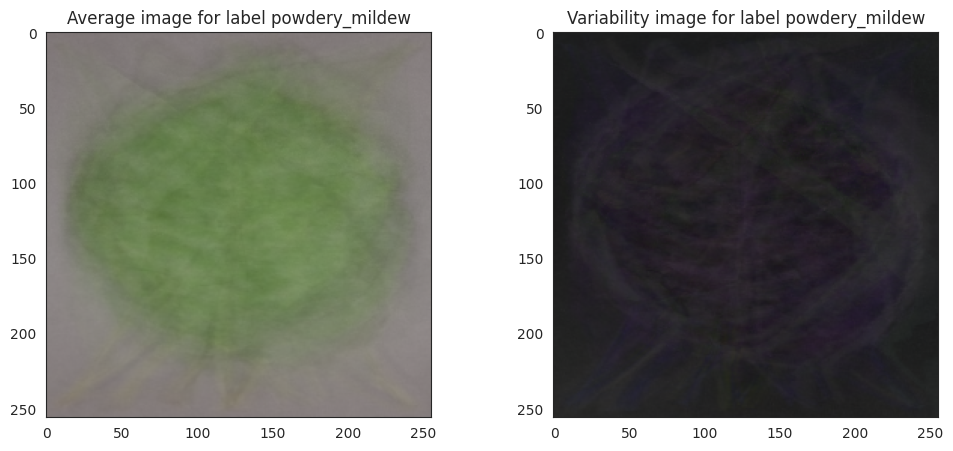

In [19]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True) 

---
## Difference between average healthy and average powdery mildew-infected leaf images 
---

This function plots the average image of healthy leaves, the average image of powdery mildew-infected leaves, and the average difference between the two images. 

In [20]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it using boolean
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return 

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


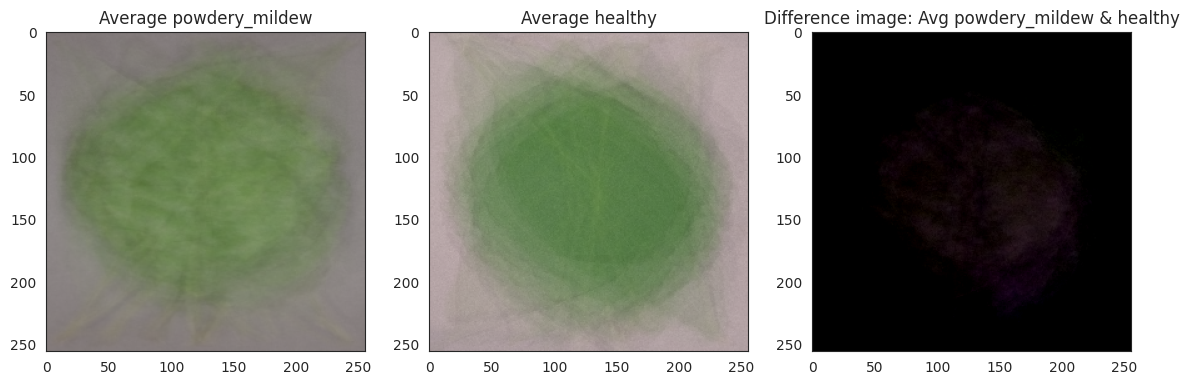

In [22]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='powdery_mildew', label_2='healthy',
                                        figsize=(14,10),
                                        save_image=True 
                                        ) 

---
## Image Montage

- **Business requirement 1** includes an image montage for each class. 
- The below function creates a montage of healthy or infected leaves for display on the dashboard.


In [23]:
import itertools
import random
sns.set_style("white") 

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    Check if your montage space is greater than the subset size
    Checks the directory for the existence of the label
    Loads and plots a given image by creating a list of axes indices
    based on nrows and ncols,
    within a for loop
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")
    


Run Montage in all labels:

In [ ]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

powdery_mildew


---

---
## Conclusions & Next Steps

* The average and variability of images of healthy and infected leaves has been plotted. 
* The differenecs between the averages of both types of leaves has been calculated. 
* An image montage of both types of leaves has been created. 
* These meet business requirement 1. 

* The next steps will be to create the Machine Learning System that can predict whether a leaf is healthy or contains the powdery mildew infection. 
* A Neural Network wil be created to map the relationships between fetures and labels 

---

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
